In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from genome.read_fasta import seq_iter
from stream.sketch import CountMinMemory
from Angus.approximation import distfinder, err_distfinder

Cannot use compiled code


In [60]:
def minim(lst):
    a = np.inf
    for pos, i in enumerate(lst):
        if i < a:
            a = i
        else:
            return pos
    return np.inf

def maxim(lst):
    a = np.inf
    min_found = False
    for pos, i in enumerate(lst):
        if i < a:
            if min_found and i > 1000:
                return pos
            else:
                a = i
        else:
            min_found = True
            a = i
    return 1
        
def error_free(lst):
    val = minim(lst)
    return lst[val:]

def error_rate(lst):
    val = minim(lst)
    num_error, num_correct = 0, 0
    for pos, i in enumerate(lst):
        if pos > val:
            num_correct += i[0]*i[1]
        else:
            num_error += i[0]*i[1]
    return num_error/(num_error + num_correct)

def num_kmers(lst):
    val = minim(lst)
    kmers = 0
    for pos, i in enumerate(lst):
        if pos > val:
            kmers += i
    return kmers

def plot(true, estimate):
    if len(true) > len(estimate):
        x = [i for i in range(1, len(estimate))]
        plt.plot(x, true[1:len(estimate)], x, estimate[1:])
    else:
        x = [i for i in range(1, len(true))]
        plt.plot(x, true[1:], x, estimate[1:len(true)])
    plt.show()

In [3]:
def read_some_data(amount, size, sketch, reads, klen):
    acc = 0
    for i in reads:
        acc += 1
        size += 80
        for j in range(80):
            kmer = i[j : j + klen]
            sketch.update(kmer)
        if acc >= amount:
            break
    return size, sketch

In [4]:
reads = seq_iter('genome/reads-aunt_01.fa.gz')
klen = 21
sketch = CountMinMemory()
amount, sketch = read_some_data(60000, 0, sketch, reads, klen)

In [37]:
data = sketch.get_feat()
counts = [x[1] for x in enumerate(np.bincount(data))]

In [143]:
def difference(counts1, counts2):
    error_in_error = (np.absolute(np.log(max(1, counts1[1])/max(1, counts2[1]))) + 
                      0.5*np.absolute(np.log(max(1, counts1[2])/max(1, counts2[2]))))
    max1, max2 = maxim(counts1), maxim(counts2)
    error_in_size = (np.absolute(np.log(max(1, counts1[max1 - 1])/max(1, counts2[max2 - 1]))) + 
                     0.5*np.absolute(np.log(max(1, counts1[max1])/max(1, counts2[max2]))) + 
                     0.5*np.absolute(np.log(max(1, counts1[max1 + 1])/max(1, counts2[max2 + 1]))))
    return error_in_error + error_in_size

def total_Variation(counts1, counts2):
    return np.log(sum(abs(counts1[i] - counts2[i]) for i in range(1, min(len(counts1), len(counts2)))))

def hellinger(counts1, counts2):
    return np.log(sum((np.sqrt(counts1[i]) - np.sqrt(counts2[i]))**2 for i in range(1, min(len(counts1), len(counts2)))))

Using Coordinate descent and Golden-Section Search to find a minimum for each of these possible evaluation functions.

In [112]:
phi = (1 + np.sqrt(5))/2

def gss_genome(counts, genome_min, genome_max, error, reads, diff_method):
    print('genome')
#     freq_freq_min = err_distfinder(genome_min, reads, 50, error)
#     freq_freq_max = err_distfinder(genome_max, reads, 50, error)
    genome_mid = (genome_max + phi*genome_min)/(1 + phi)
    freq_freq_mid = err_distfinder(int(genome_mid), reads, 50, error)
    while (genome_max - genome_min) > 100:
#         print(genome_max - genome_min)
        new_genome_guess = genome_min + genome_max - genome_mid
        new_freq_freq = err_distfinder(int(new_genome_guess), reads, 50, error)
        if genome_mid - genome_min > genome_max - genome_mid:
            if diff_method(new_freq_freq, counts) > diff_method(freq_freq_mid, counts):
                genome_min = new_genome_guess
#                 freq_freq_min = new_freq_freq
            else:
                genome_max, genome_mid = genome_mid, new_genome_guess
                freq_freq_mid = new_freq_freq
        else:
            if diff_method(new_freq_freq, counts) > diff_method(freq_freq_mid, counts):
                genome_max = new_genome_guess
#                 freq_freq_max = new_freq_freq
            else:
                genome_min, genome_mid = genome_mid, new_genome_guess
                freq_freq_mid = new_freq_freq
                
    return genome_min, int(genome_mid), genome_max, freq_freq_mid

def gss_errors(counts, genome, error_min, error_max, reads, diff_method):
    print('errors')
#     freq_freq_min = err_distfinder(genome, reads, 50, error_min)
#     freq_freq_max = err_distfinder(genome, reads, 50, error_max)
    error_mid = (error_max + phi*error_min)/(1 + phi)
    freq_freq_mid = err_distfinder(genome, reads, 50, error_mid)
    while (error_max - error_min) > 0.000001:
#         print(error_max - error_min)
        new_error_guess = error_min + error_max - error_mid
        new_freq_freq = err_distfinder(genome, reads, 50, new_error_guess)
        if error_mid - error_min > error_max - error_mid:
            if diff_method(new_freq_freq, counts) > diff_method(freq_freq_mid, counts):
                error_min = new_error_guess
#                 freq_freq_min = new_freq_freq
            else:
                error_max, error_mid = error_mid, new_error_guess
                freq_freq_mid = new_freq_freq
        else:
            if diff_method(new_freq_freq, counts) > diff_method(freq_freq_mid, counts):
                error_max = new_error_guess
#                 freq_freq_max = new_freq_freq
            else:
                error_min, error_mid = error_mid, new_error_guess
                freq_freq_mid = new_freq_freq
                
    return error_min, error_mid, error_max, freq_freq_mid    

In [161]:
def find_optimal(counts, diff_method):
    
    acc = 0
     
    minimum = minim(counts)

    reads = sum(x*y for x, y in enumerate(counts))

    if minimum == np.inf:
        genome_guess = sum(counts)
        error_guess = 1/100
    else:
        genome_guess = sum(counts[1 + minim(counts):])
        error_guess = 1 - (sum(x*y for x, y in enumerate(counts) if x > minimum)/reads)

    genome_max = genome_guess*1.5
    genome_min = genome_guess*0.7
    error_max = min(0.5, error_guess*10)
    error_min = error_guess*0.001

    genome_min, new_genome_guess, genome_max, _ = gss_genome(counts, genome_min, genome_max, error_guess, reads, diff_method)
    
    error_min, new_error_guess, error_max, freq_freq = gss_errors(counts, new_genome_guess, error_min, error_max, reads, diff_method)

    while (np.absolute(genome_guess - new_genome_guess) > 1000) and (np.absolute(error_guess - new_error_guess) > 0.000001) and (acc < 5):
        acc += 1
        genome_guess = new_genome_guess
        error_guess = new_error_guess

        genome_max = int(genome_guess*1.5)
        genome_min = int(genome_guess*0.7)
        error_max = min(0.5, error_guess*10)
        error_min = error_guess*0.001

        genome_min, new_genome_guess, genome_max, _ = gss_genome(counts, genome_min, genome_max, error_guess, reads, diff_method)
        error_min, new_error_guess, error_max, freq_freq = gss_errors(counts, new_genome_guess, error_min, error_max, reads, diff_method)

    return new_genome_guess, new_error_guess, freq_freq

In [139]:
gen, err, freq = find_optimal(counts, difference)

genome
errors
genome
errors


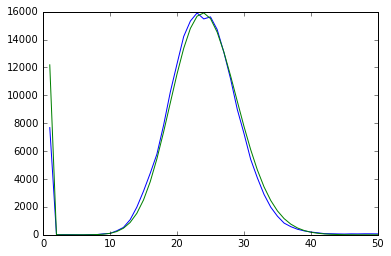

In [140]:
plot(counts, freq)

In [144]:
gen1, err1, freq1 = find_optimal(counts, total_Variation)

genome
errors


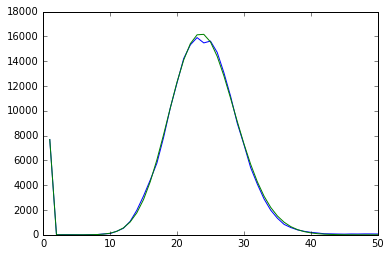

In [145]:
plot(counts, freq1)

In [146]:
gen2, err2, freq2 = find_optimal(counts, hellinger)

genome
errors


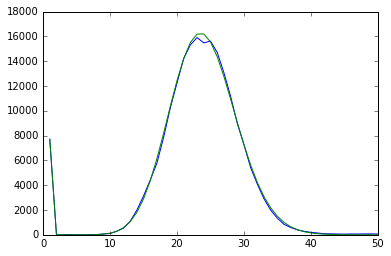

In [147]:
plot(counts, freq2)

In [ ]:
x = [i for i in range(1, 50)]
plt.plot(x, counts[1:50], x, freq[1:50], x, freq1[1:50], x, freq2[1:50])
plt.show()

In [148]:
print(gen, err)
print(gen1, err1)
print(gen2, err2)

196536 0.00254056753047
199207 0.00160159333528
199584 0.00161069657954


In [165]:
reads = seq_iter('genome/reads-aunt_01.fa.gz')
klen = 21
sketch = CountMinMemory()
amount, sketch = read_some_data(7500, 0, sketch, reads, klen)

In [154]:
data = sketch.get_feat()
counts_low = [x[1] for x in enumerate(np.bincount(data))]

In [162]:
gen_low, err_low, freq_low = find_optimal(counts_low, difference)
gen1_low, err1_low, freq1_low = find_optimal(counts_low, total_Variation)
gen2_low, err2_low, freq2_low = find_optimal(counts_low, hellinger)

genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors
genome
errors


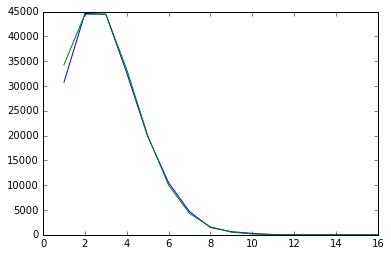

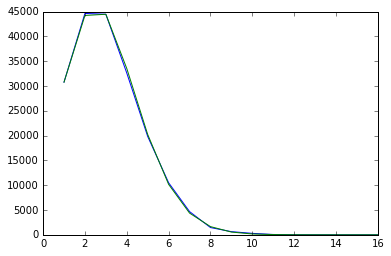

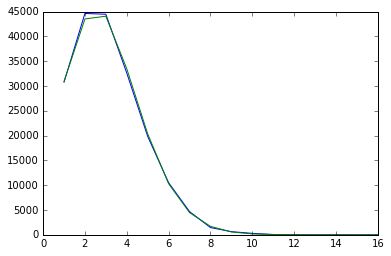

In [163]:
plot(counts_low, freq_low)
plot(counts_low, freq1_low)
plot(counts_low, freq2_low)

In [164]:
print(gen_low, err_low)
print(gen1_low, err1_low)
print(gen2_low, err2_low)

198471 0.00774849907559
198461 0.00241124546519
196752 0.0037687959541


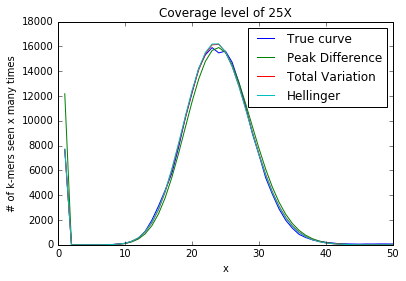

In [173]:
x = [i for i in range(1, 51)]
plt.plot(x, counts[1:51], label = 'True curve')
plt.plot(x, freq[1:51], label = 'Peak Difference')
plt.plot(x, freq1[1:51], label = 'Total Variation')
plt.plot(x, freq2[1:51], label = 'Hellinger')
plt.legend()
plt.title('Coverage level of 25X')
plt.ylabel('# of k-mers seen x many times')
plt.xlabel('x')
plt.savefig('Angus/figures/high_coverage_estimates.png')
plt.show()

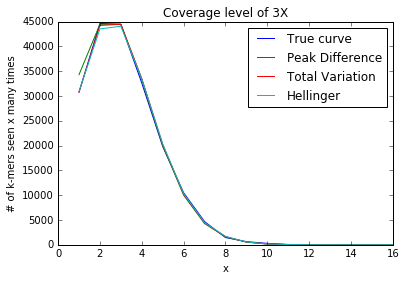

In [174]:
x = [i for i in range(1, 17)]
plt.plot(x, counts_low[1:17], label = 'True curve')
plt.plot(x, freq_low[1:17], label = 'Peak Difference')
plt.plot(x, freq1_low[1:17], label = 'Total Variation')
plt.plot(x, freq2_low[1:17], label = 'Hellinger')
plt.legend()
plt.title('Coverage level of 3X')
plt.ylabel('# of k-mers seen x many times')
plt.xlabel('x')
plt.savefig('Angus/figures/low_coverage_estimates.png')
plt.show()